# Deploy Llama 2 on AWS inferentia2 with Amazon SageMaker

In this end-to-end tutorial, you will learn how to deploy and speed up Llama 2 inference using AWS Inferentia2 and [optimum-neuron](https://huggingface.co/docs/optimum-neuron/index) on Amazon SageMaker. [Optimum Neuron](https://huggingface.co/docs/optimum-neuron/index) is the interface between the Hugging Face Transformers & Diffusers library and AWS Accelerators including AWS Trainium and AWS Inferentia2. 

You will learn how to: 

1. Convert Llama 2 to AWS Neuron (Inferentia2) with `optimum-neuron`
2. Create a custom `inference.py` script for Llama 2
3. Upload the neuron model and inference script to Amazon S3
4. Deploy a Real-time Inference Endpoint on Amazon SageMaker
5. Generate images using the deployed model

## Quick intro: AWS Inferentia 2

[AWS inferentia (Inf2)](https://aws.amazon.com/de/ec2/instance-types/inf2/) are purpose-built EC2 for deep learning (DL) inference workloads. Inferentia 2 is the successor of [AWS Inferentia](https://aws.amazon.com/ec2/instance-types/inf1/?nc1=h_ls), which promises to deliver up to 4x higher throughput and up to 10x lower latency.

| instance size | accelerators | Neuron Cores | accelerator memory | vCPU | CPU Memory | on-demand price ($/h) |
| ------------- | ------------ | ------------ | ------------------ | ---- | ---------- | --------------------- |
| inf2.xlarge   | 1            | 2            | 32                 | 4    | 16         | 0.76                  |
| inf2.8xlarge  | 1            | 2            | 32                 | 32   | 128        | 1.97                  |
| inf2.24xlarge | 6            | 12           | 192                | 96   | 384        | 6.49                  |
| inf2.48xlarge | 12           | 24           | 384                | 192  | 768        | 12.98                 |

Additionally, inferentia 2 will support the writing of custom operators in c++ and new datatypes, including `FP8` (cFP8).

Let's get started! 🚀

*If you are going to use Sagemaker in a local environment (not SageMaker Studio or Notebook Instances). You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it.*

## 1. Convert Llama 2 to AWS Neuron (Inferentia2) with `optimum-neuron`

We are going to use the [optimum-neuron](https://huggingface.co/docs/optimum-neuron/index) to compile/convert our model to neuronx. Optimum Neuron provides a set of tools enabling easy model loading, training and inference on single- and multi-Accelerator settings for different downstream tasks. 

As a first step, we need to install the `optimum-neuron` and other required packages.

*Tip: If you are using Amazon SageMaker Notebook Instances or Studio you can go with the `conda_python3` conda kernel.*

In [ ]:
# Install the required packages
%pip install "optimum-neuron==0.0.13" --upgrade
%pip install "sagemaker>=2.197.0"  --upgrade

After we have installed the `optimum-neuron` we can convert load and convert our model.

We are going to use the [meta-llama/Llama-2-7b-chat-hf](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf) model. Llama 2 is a collection of pretrained and fine-tuned generative text models ranging in scale from 7 billion to 70 billion parameters. This is the repository for the 7B fine-tuned model, optimized for dialogue use cases.

At the time of writing, the [AWS Inferentia2 does not support dynamic shapes for inference](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/arch/neuron-features/dynamic-shapes.html?highlight=dynamic%20shapes#), which means that the we need to specify our image size in advanced for compiling and inference. 

In simpler terms, this means we need to define the input shapes for our prompt (sequence length), batch size, height and width of the image.

We precompiled the model with the following parameters and pushed it to the Hugging Face Hub: 
* `sequence_length`: 2048
* `batch_size`: 4
* `neuron`: 2.15.0


_Note: If you want to compile your own model or a different Llama 2 checkpoint you need to use ~120GB of memory and the compilation can take ~45 minutes. We used an `inf2.8xlarge` ec2 instance with the [Hugging Face Neuron Deep Learning AMI](https://aws.amazon.com/marketplace/pp/prodview-gr3e6yiscria2) to compile the model._

In [ ]:
from huggingface_hub import snapshot_download

# compiled model id
compiled_model_id = "aws-neuron/"

# save compiled model to local directory
save_directory = "llama_neuron"
# Downloads our compiled model from the HuggingFace Hub 
# using the revision as neuron version reference
# and makes sure we exlcude the symlink files and "hidden" files, like .DS_Store, .gitignore, etc.
snapshot_download(compiled_model_id, revision="2.15.0", local_dir=save_directory, local_dir_use_symlinks=False, allow_patterns=["[!.]*.*"])


###############################################
# COMMENT IN BELOW TO COMPILE DIFFERENT MODEL #
###############################################
#
# from optimum.neuron import NeuronStableDiffusionXLPipeline
#
# # model id you want to compile
# vanilla_model_id = "meta-llama/Llama-2-7b-chat-hf"
#
# # configs for compiling model
# compiler_args = {"num_cores": 2, "auto_cast_type": "fp16"}
# input_shapes = {
#   "sequence_length": 2048, # max length to generate
#   "batch_size": 1 # batch size for the model
#   }
#
# llm = NeuronModelForCausalLM.from_pretrained(vanilla_model_id, export=True, **input_shapes, **compiler_args)
#
# # Save locally or upload to the HuggingFace Hub
# save_directory = "llama_neuron"
# llm.save_pretrained(save_directory)

## 2. Create a custom `inference.py` script for Stable Diffusion

The [Hugging Face Inference Toolkit](https://github.com/aws/sagemaker-huggingface-inference-toolkit) supports zero-code deployments on top of the [pipeline feature](https://huggingface.co/transformers/main_classes/pipelines.html) from 🤗 Transformers. This allows users to deploy Hugging Face transformers without an inference script [[Example](https://github.com/huggingface/notebooks/blob/master/sagemaker/11_deploy_model_from_hf_hub/deploy_transformer_model_from_hf_hub.ipynb)]. 

Currently is this feature not supported with AWS Inferentia2, which means we need to provide an `inference.py` for running inference. But `optimum-neuron` has integrated support for the 🤗 Diffusers pipeline feature. That way we can use the `optimum-neuron` to create a pipeline for our model.

If you want to know more about the `inference.py` script check out this [example](https://github.com/huggingface/notebooks/blob/master/sagemaker/17_custom_inference_script/sagemaker-notebook.ipynb). It explains amongst other things what the `model_fn` and `predict_fn` are. 

In [ ]:
# create code directory in our model directory
!mkdir {save_directory}/code

We are using the `NEURON_RT_NUM_CORES=2` to make sure that each HTTP worker uses 2 Neuron core to maximize throughput.

In [ ]:
%%writefile {save_directory}/code/inference.py
import os
# To use two neuron core per worker
os.environ["NEURON_RT_NUM_CORES"] = "2"
import torch
import torch_neuronx
import base64
from io import BytesIO
from optimum.neuron import pipeline


def model_fn(model_dir):
    # load local converted model into pipeline
    pipeline = pipeline('text-generation', model_dir)
    return pipeline


def predict_fn(data, pipeline):
    # extract prompt from data
    prompt = data.pop("inputs", data)
    
    parameters = data.pop("parameters", None)
    
    if parameters is not None:
        output = pipeline(prompt, **parameters)[0]
    else:
        output = pipeline(prompt)[0]
        
    return output

## 3. Upload the neuron model and inference script to Amazon S3

Before we can deploy our neuron model to Amazon SageMaker we need to upload it all our model artifacts to Amazon S3.

_Note: Currently `inf2` instances are only available in the `us-east-2` & `us-east-1` region [[REF](https://aws.amazon.com/de/about-aws/whats-new/2023/05/sagemaker-ml-inf2-ml-trn1-instances-model-deployment/)]. Therefore we need to force the region to us-east-2._

Lets create our SageMaker session and upload our model to Amazon S3.

In [ ]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")
assert sess.boto_region_name in ["us-east-2", "us-east-1"] , "region must be us-east-2 or us-west-2, due to instance availability"

We create our `model.tar.gz` with our `inference.py`` script


In [ ]:
# create a model.tar.gz archive with all the model artifacts and the inference.py script.
%cd {save_directory}
!tar zcvf model.tar.gz *
%cd ..

Next, we upload our `model.tar.gz` to Amazon S3 using our session bucket and `sagemaker` sdk.

In [ ]:
from sagemaker.s3 import S3Uploader

# create s3 uri
s3_model_path = f"s3://{sess.default_bucket()}/neuronx/llama"

# upload model.tar.gz
s3_model_uri = S3Uploader.upload(local_path=f"{save_directory}/model.tar.gz", desired_s3_uri=s3_model_path)
print(f"model artifcats uploaded to {s3_model_uri}")

## 4. Deploy a Real-time Inference Endpoint on Amazon SageMaker

After we have uploaded our model artifacts to Amazon S3 can we create a custom `HuggingfaceModel`. This class will be used to create and deploy our real-time inference endpoint on Amazon SageMaker.

The `inf2.xlarge` instance type is the smallest instance type with AWS Inferentia2 support. It comes with 1 Inferentia2 chip with 2 Neuron Cores. This means we can use 2 Neuron Cores to minimize latency for our image generation. 

In [ ]:
from sagemaker.huggingface.model import HuggingFaceModel

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,        # path to your model.tar.gz on s3
   role=role,                      # iam role with permissions to create an Endpoint
   transformers_version="4.34.1",  # transformers version used
   pytorch_version="1.13.1",       # pytorch version used
   py_version='py310',             # python version used
   model_server_workers=1,         # number of workers for the model server
)

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,      # number of instances
    instance_type="ml.inf2.xlarge", # AWS Inferentia Instance
    volume_size = 100
)
# ignore the "Your model is not compiled. Please compile your model before using Inferentia." warning, we already compiled our model.

# 5. Run inference on Llama 2

The `.deploy()` returns an `HuggingFacePredictor` object which can be used to request inference. Our endpoint expects a `json` with at least `messages` key. Since we are leveraging the new [apply_chat_template](https://huggingface.co/docs/transformers/main/en/internal/tokenization_utils#transformers.PreTrainedTokenizerBase.apply_chat_template) in our inference.py script we can send "openai" like converstaions to our model. 

Additionally we can send inference parameters, e.g. `top_p` or `temperature` using the `parameters` key.

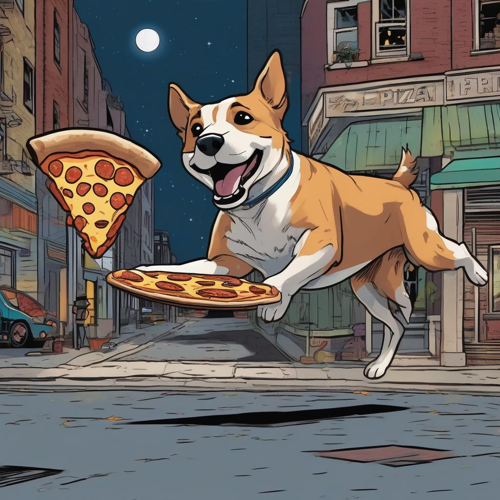

In [47]:
prompt = "A dog trying catch a flying pizza at a street corner, comic book, well lit, night time"

# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "parameters": {
    "num_inference_steps" : 25,
    "negative_prompt" : "disfigured, ugly, deformed"
    } 
  }
)

# decode and display image
display_image(decode_base64_image(response["generated_images"][0]))

### Delete model and endpoint

To clean up, we can delete the model and endpoint.

In [48]:
predictor.delete_model()
predictor.delete_endpoint()